In [2]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
import cv2
from scipy import ndimage
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
q3_images = '/content/drive/My Drive/Colab Notebooks/Q3'

Mounted at /content/drive


Part I

---


Q1.3

In [4]:
square = np.full((1000, 1000), 255.0)
square[450:550, 450:550] = 0.0
max_response = float('-inf')
optimal_sigma = float('-inf')
for sigma in np.linspace(0.001, 1, 101):
    matrix = sigma ** 2 * ndimage.gaussian_laplace(square, sigma=sigma)
    response = max(np.max(matrix), abs(np.min(matrix)))
    if response > max_response:
        max_response = response
        optimal_sigma = sigma
print(f'Sigma = {optimal_sigma}')

Sigma = 0.07093


Part II

---



(286, 230)


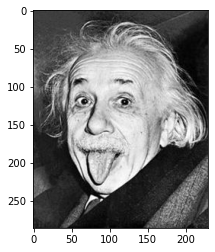

In [5]:
img = cv2.imread(q3_images + '/1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
print(gray.shape)

Step 1

In [6]:
def get_gradmag_angle(img, threshold=0.01):
    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1)

    mag = cv2.magnitude(Ix, Iy)
    mag[mag < threshold] = 0

    rad = np.arctan2(Iy, Ix)
    deg = np.rad2deg(np.where(rad < 0, rad + np.pi, rad))
    return mag, deg

mag, deg = get_gradmag_angle(gray)

Step 2

In [7]:
def create_grid(img, size=8):
    m, n = img.shape
    grid_m = m // size
    grid_n = n // size
    return grid_m, grid_n

grid_m, grid_n = create_grid(gray)
print(grid_m, grid_n)

35 28


Step 3

In [8]:
mag_histogram = np.zeros((grid_m, grid_n, 6))
occ_histogram = np.zeros((grid_m, grid_n, 6))
deg_bin = deg + 15
deg_bin[deg_bin > 180] -= 180
bins = np.floor_divide(deg_bin, 30).astype(int)

def process_pixel(cell_i, cell_j, use_magnitude=True, size=8):
    start_pixel_i = cell_i * size
    start_pixel_j = cell_j * size
    for i in range(start_pixel_i, start_pixel_i + size):
        for j in range(start_pixel_j, start_pixel_j + size):
            if use_magnitude:
                mag_histogram[cell_i, cell_j, bins[i, j]] += mag[i, j]
            elif mag[i, j].any() > 0:
                occ_histogram[cell_i, cell_j, bins[i, j]] += 1

def form_histogram(use_magnitude=True):
    for i in range(grid_m):
        for j in range(grid_n):
            process_pixel(i, j, use_magnitude)

form_histogram(use_magnitude=True)
form_histogram(use_magnitude=False)

Visualize

In [9]:
def plot_quiver(histogram, size=8):
    x, y, u, v = [], [], [], []
    m, n, _ = histogram.shape
    for i in range(m):
        for j in range(n):
            for l in range(6):
                x.append(j * size + size // 2)
                y.append(i * size + size // 2)
                u.append(histogram[i][j][l] * np.sin(np.pi / 6 * l))
                v.append(histogram[i][j][l] * np.cos(np.pi / 6 * l))
    return x, y, u, v 

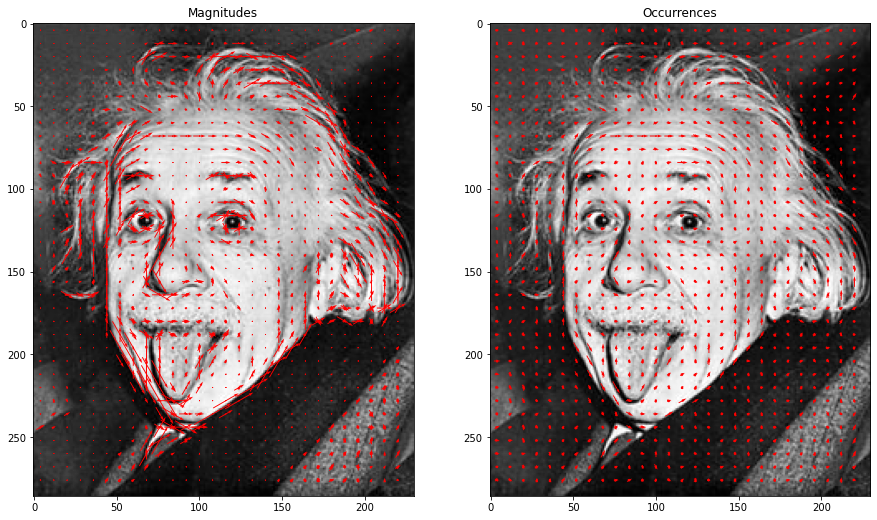

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 13))

ax[0].set_title('Magnitudes')
x, y, u, v = plot_quiver(mag_histogram)
ax[0].imshow(gray, cmap='gray')
ax[0].quiver(x, y, u, v, color='red', pivot='middle')

ax[1].set_title('Occurrences')
x, y, u, v = plot_quiver(occ_histogram)
ax[1].imshow(gray, cmap='gray')
ax[1].quiver(x, y, u, v, color='red', pivot='middle')

plt.show()

Accumulating gradient magnitudes method tends to draw better quiver than counting the occurances around the edge area like chin, nose and eyes.

Use Magnitudes for the rest

Step 4

In [11]:
def normalize_histogram(histogram):
    block_size = 2
    e = 0.001
    m, n, _ = histogram.shape
    normalized = np.zeros((m - 1, n - 1, 24))
    for i in range(m - 1):
        for j in range(n - 1):
            result = histogram[i:i + block_size, j:j + block_size, :].reshape(-1, )
            normalized[i][j] = result / np.sum(np.sqrt(np.square(result) + np.square(e)))
    return normalized

In [12]:
normalized_histogram = normalize_histogram(mag_histogram)
np.savetxt('/content/drive/My Drive/Colab Notebooks/1.txt', normalized_histogram.reshape(-1, ))

Flash / No Flash photos

In [13]:
flash = cv2.imread('/content/drive/My Drive/Colab Notebooks/flash.jpg')
flash = cv2.cvtColor(flash, cv2.COLOR_BGR2GRAY)

noflash = cv2.imread('/content/drive/My Drive/Colab Notebooks/noflash.jpg')
noflash = cv2.cvtColor(noflash, cv2.COLOR_BGR2GRAY)

In [14]:
flash_mag, flash_deg = get_gradmag_angle(flash)
noflash_mag, noflash_deg = get_gradmag_angle(noflash)
flash_grid_m, flash_grid_n = create_grid(flash)
noflash_grid_m, noflash_grid_n = create_grid(noflash)

flash_mag_histogram = np.zeros((flash_grid_m, flash_grid_n, 6))
noflash_mag_histogram = np.zeros((noflash_grid_m, noflash_grid_n, 6))

flash_deg_bin = flash_deg + 15
flash_deg_bin[flash_deg_bin > 180] -= 180
flash_bins = np.floor_divide(flash_deg_bin, 30).astype(int)
noflash_deg_bin = noflash_deg + 15
noflash_deg_bin[noflash_deg_bin > 180] -= 180
noflash_bins = np.floor_divide(noflash_deg_bin, 30).astype(int)

def process_pixel(cell_i, cell_j, is_flash=True, size=8):
    start_pixel_i = cell_i * size
    start_pixel_j = cell_j * size
    for i in range(start_pixel_i, start_pixel_i + size):
        for j in range(start_pixel_j, start_pixel_j + size):
            if is_flash:
                flash_mag_histogram[cell_i, cell_j, flash_bins[i, j]] += flash_mag[i, j]
            else:
                noflash_mag_histogram[cell_i, cell_j, noflash_bins[i, j]] += noflash_mag[i, j]

def form_histogram(is_flash=True):
    if is_flash:
        for i in range(flash_grid_m):
            for j in range(flash_grid_n):
                process_pixel(i, j, is_flash)
    else:
        for i in range(noflash_grid_m):
            for j in range(noflash_grid_n):
                process_pixel(i, j, is_flash)

form_histogram(is_flash=True)
form_histogram(is_flash=False)

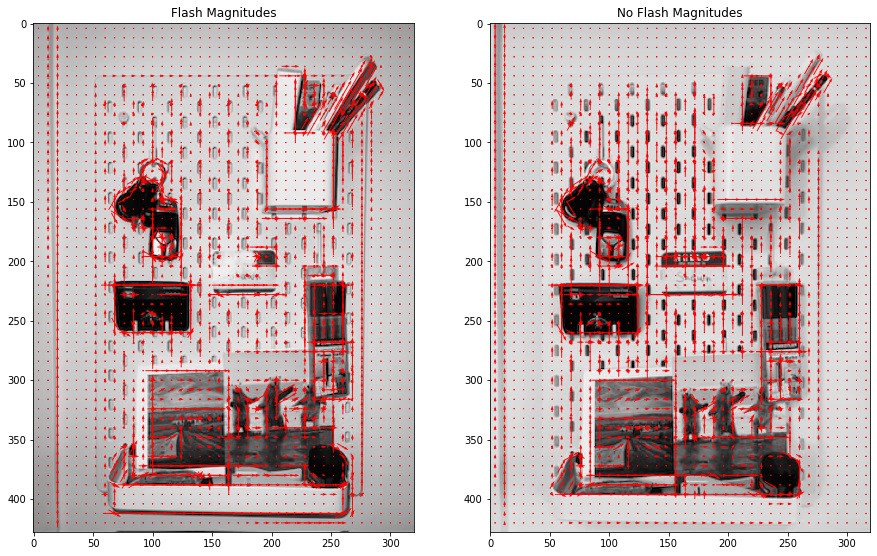

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 13))

ax[0].set_title('Flash Magnitudes')
x, y, u, v = plot_quiver(flash_mag_histogram)
ax[0].imshow(flash, cmap='gray')
ax[0].quiver(x, y, u, v, color='red', pivot='middle')

ax[1].set_title('No Flash Magnitudes')
x, y, u, v = plot_quiver(noflash_mag_histogram)
ax[1].imshow(noflash, cmap='gray')
ax[1].quiver(x, y, u, v, color='red', pivot='middle')

plt.show()

In [16]:
normalized_flash_histogram = normalize_histogram(flash_mag_histogram)
np.savetxt('/content/drive/My Drive/Colab Notebooks/normalized_flash.txt', normalized_flash_histogram.reshape(-1, ))

normalized_noflash_histogram = normalize_histogram(noflash_mag_histogram)
np.savetxt('/content/drive/My Drive/Colab Notebooks/normalized_noflash.txt', normalized_noflash_histogram.reshape(-1, ))

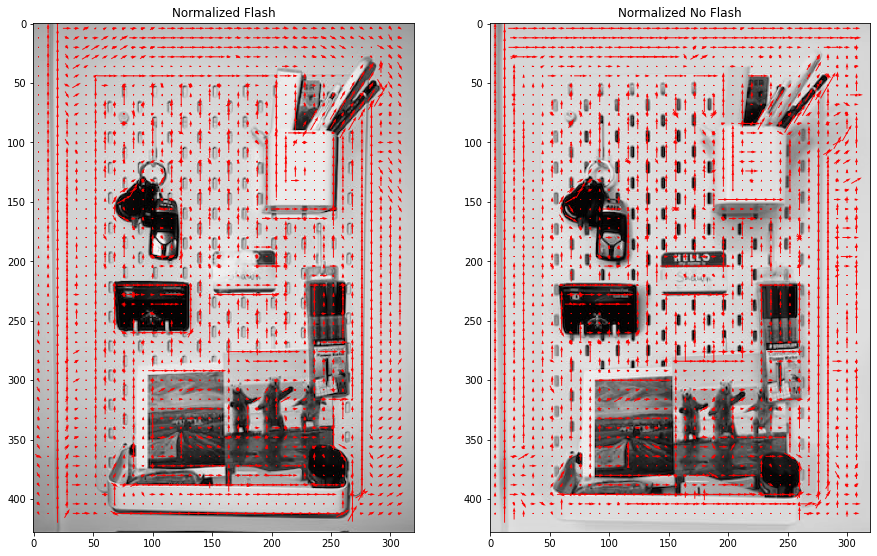

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 13))

ax[0].set_title('Normalized Flash')
x, y, u, v = plot_quiver(normalized_flash_histogram)
ax[0].imshow(flash, cmap='gray')
ax[0].quiver(x, y, u, v, color='red', pivot='middle')

ax[1].set_title('Normalized No Flash')
x, y, u, v = plot_quiver(normalized_noflash_histogram)
ax[1].imshow(noflash, cmap='gray')
ax[1].quiver(x, y, u, v, color='red', pivot='middle')

plt.show()

The normalization of HOG is not beneficial in my case. The reason may because the normalized HOG can decrease large magnitude effect and results in a lot of noises for the white wall and the white board I'm taking picture of. Besides, the flash light photo seems to perform better (ignoring the light reflection), because the flash light produce the shadow of the picture which result in a greater weight in the edge.

Q4

Step 1

In [19]:
img1 = cv2.imread('/content/drive/My Drive/Colab Notebooks/q4_1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/drive/My Drive/Colab Notebooks/q4_2.jpg', cv2.IMREAD_GRAYSCALE)

In [20]:
def second_moment_matrix(img, sigma=2):
    m, n = img.shape
    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1)

    Ix2_blur = cv2.GaussianBlur(Ix ** 2, (9, 9), sigma)
    Iy2_blur = cv2.GaussianBlur(Iy ** 2, (9, 9), sigma)
    IxIy_blur = cv2.GaussianBlur(Ix * Iy, (9, 9), sigma)

    e = np.zeros((m, n, 2))
    for i in range(m):
        for j in range(n):
            e[i][j] = np.linalg.eigvals(np.array([[Ix2_blur[i][j], IxIy_blur[i][j]],
                                                  [IxIy_blur[i][j], Iy2_blur[i][j]]]))
    return e

In [21]:
e1 = second_moment_matrix(img1)
e2 = second_moment_matrix(img2)

Step 2

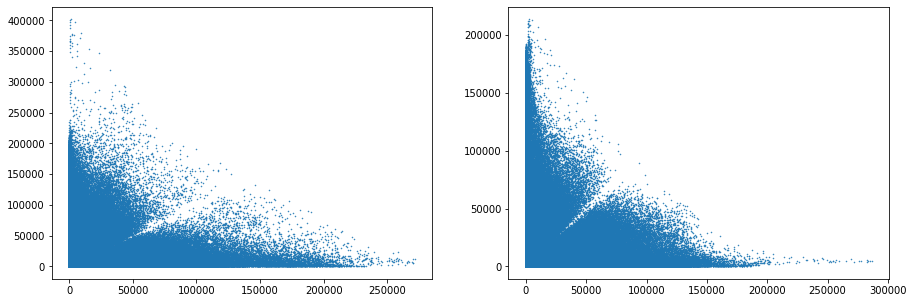

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
e1_x, e1_y = e1[:,:,0], e1[:,:,1]
ax[0].scatter(e1_x, e1_y, s=0.25)

e2_x, e2_y = e2[:,:,0], e2[:,:,1]
ax[1].scatter(e2_x, e2_y, s=0.25)

plt.show()

Step 3

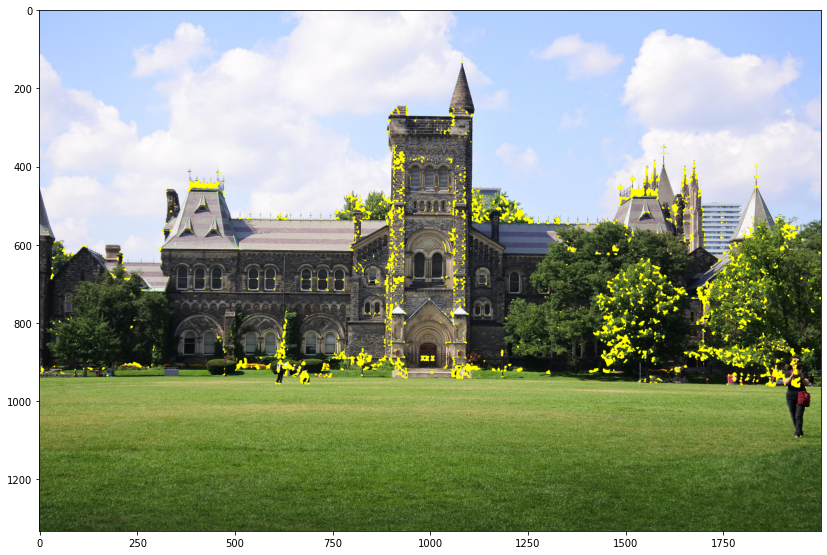

In [23]:
img1 = cv2.imread('/content/drive/My Drive/Colab Notebooks/q4_1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

threshold = 2e4
_min = np.minimum(e1_x, e1_y)
img1[_min > threshold] = [255, 255, 0]
plt.figure(figsize=(14,12))
plt.imshow(img1)

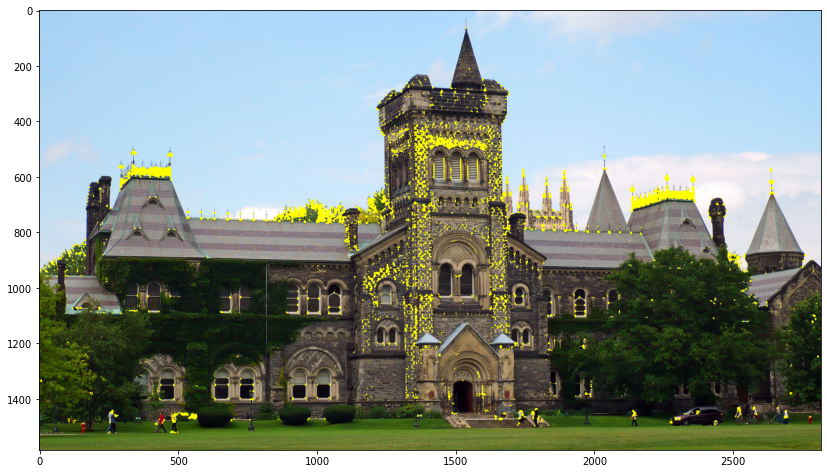

In [24]:
img2 = cv2.imread('/content/drive/My Drive/Colab Notebooks/q4_2.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

threshold = 1e4
_min = np.minimum(e2_x, e2_y)
img2[_min > threshold] = [255, 255, 0]
plt.figure(figsize=(14,12))
plt.imshow(img2)

Step 4

In [25]:
img1 = cv2.imread('/content/drive/My Drive/Colab Notebooks/q4_1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/drive/My Drive/Colab Notebooks/q4_2.jpg', cv2.IMREAD_GRAYSCALE)

In [26]:
e1 = second_moment_matrix(img1, sigma=10)
e2 = second_moment_matrix(img2, sigma=10)

In [27]:
e1_x, e1_y = e1[:,:,0], e1[:,:,1]
e2_x, e2_y = e2[:,:,0], e2[:,:,1]

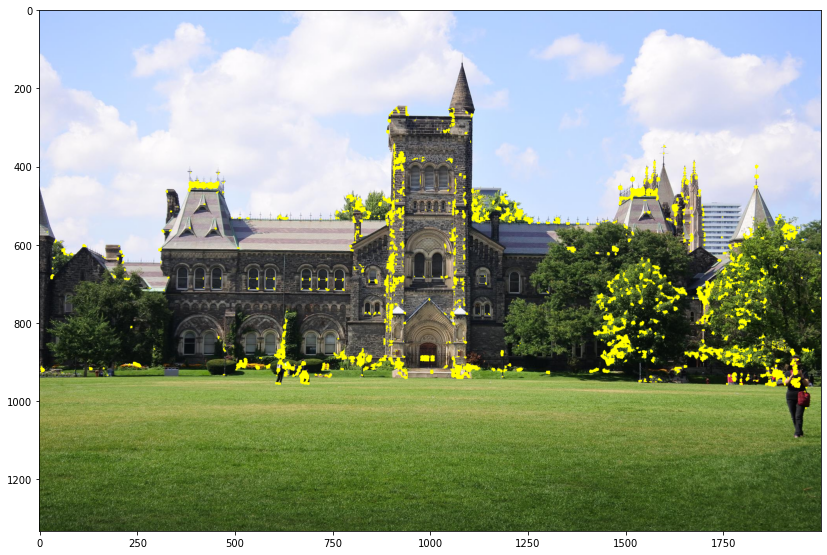

In [28]:
img1 = cv2.imread('/content/drive/My Drive/Colab Notebooks/q4_1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

threshold = 2e4
_min = np.minimum(e1_x, e1_y)
img1[_min > threshold] = [255, 255, 0]
plt.figure(figsize=(14,12))
plt.imshow(img1)

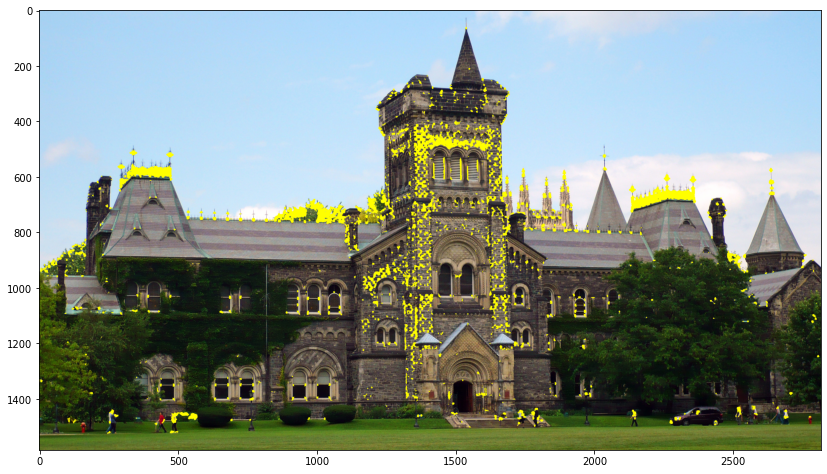

In [29]:
img2 = cv2.imread('/content/drive/My Drive/Colab Notebooks/q4_2.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

threshold = 1e4
_min = np.minimum(e2_x, e2_y)
img2[_min > threshold] = [255, 255, 0]
plt.figure(figsize=(14,12))
plt.imshow(img2)

Larger and more corners are detected for larger sigma, and vice versa. This is because the larger sigma will result more weight in the boundary and less weight in the content with the same threshold.